In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import torchvision.datasets as dsets
import math
import torchvision.models as models
from PIL import Image
from deepfool import deepfool
import os,sys
from FGSM import fgsm,fgsm_graybox
from train_mnist_model import Net
from tqdm import tqdm
from torch.distributions.categorical import Categorical

# homedir = '/home/nikhil/Examining-Robustness-of-BNNs-to-Adversarial-Examples/'
homedir = '/home/serge/Documents/Classes/Adversarial_ML/Examining-Robustness-of-BNNs-to-Adversarial-Examples/'
MODULE_PATH = ['{}BNN_Implementations/PyTorch-BayesianCNN-master'.format(homedir),
          '{}BNN_Implementations/PyTorch-BayesianCNN-master/models/BayesianModels'.format(homedir)]

for m in MODULE_PATH:
    sys.path.append(m)

import data
from BayesianLeNet import BBBLeNet
import metrics

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.1307,), (0.3081,))])
# test_loader = test_loader = torch.utils.data.DataLoader(
#         dsets.MNIST('../data', train=False, transform=transforms.Compose([
#                            transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
#                        ])),
#         batch_size=1000, shuffle=False)

dataset = 'MNIST'
batch_size=1000
valid_size = 0.2 # will not be used 
num_workers = 0

trainset, testset, inputs, outputs = data.getDataset(dataset)
train_loader, valid_loader, test_loader = data.getDataloader(trainset, testset, valid_size, 
                                                             batch_size, num_workers)


In [4]:
def attack_fgsm(model,loss,eps,device,loader,is_bayes=False):
    original_preds_soft = []
    attack_preds_soft = []
    for batch_idx, (images, labels) in enumerate(loader):
        attack_images = fgsm(model=model,loss=loss,device=device,images=images,labels=labels,eps=eps,is_bayes=is_bayes)
        
        if is_bayes:
            original_preds_soft.append(model(images.to(device))[0].detach())
            attack_preds_soft.append(model(attack_images)[0].detach())
        else:
            original_preds_soft.append(model(images.to(device)).detach())
            attack_preds_soft.append(model(attack_images).detach())
        
    original_preds_soft = torch.cat(original_preds_soft, dim=0)
    attack_preds_soft = torch.cat(attack_preds_soft,dim=0)
    original_preds = torch.argmax(original_preds_soft,axis=1)
    attack_preds = torch.argmax(attack_preds_soft,axis=1)
    
    success_rate = torch.mean((original_preds!=attack_preds).type(torch.DoubleTensor)).cpu().detach().numpy()
    if(is_bayes):
        entropy = np.mean(Categorical(probs = F.softmax(attack_preds_soft,dim=0)).entropy().cpu().detach().numpy())
    else:
        entropy = np.mean(Categorical(probs = attack_preds_soft).entropy().cpu().detach().numpy())
    return success_rate,entropy,original_preds_soft,attack_preds_soft

# Example attack on a non-Bayes CNN (MNIST)

In [31]:
model = Net()
model.load_state_dict(torch.load('mnist_cnn.pt'))
model.eval()
device = torch.device('cuda:0')
model.to(device)
loss = nn.CrossEntropyLoss()
loss = nn.CrossEntropyLoss()

In [32]:
epsilons = np.linspace(0,2,101)
success_rates = []
entropies = []
for eps in tqdm(epsilons):
    success_rate,entropy = attack_fgsm(model,loss,eps,device,test_loader)
    success_rates.append(success_rate)
    entropies.append(entropy)


  0%|          | 0/101 [00:00<?, ?it/s]

RuntimeError: size mismatch, m1: [1000 x 12544], m2: [9216 x 128] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:290

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epsilons,success_rates)
plt.xlabel('epsilon')
plt.ylabel('Attack success rate')
plt.subplot(1,2,2)
plt.plot(epsilons,entropies)
plt.xlabel('epsilon')
plt.ylabel('Average predictive entropy')

# Example attack on BayesNet

In [5]:
model = BBBLeNet(outputs=10,inputs=1)
ckpt_path = 'BNN_Implementations/PyTorch-BayesianCNN-master/checkpoints/MNIST/bayesian'
ckpt_name = 'model_lenet.pt'
model.load_state_dict(torch.load(os.path.join(homedir,ckpt_path,ckpt_name)))
model.eval()
device = torch.device('cuda:0')
model.to(device)
loss = metrics.ELBO(len(test_loader.dataset)).to(device)
# loss = F.nll_loss()

In [6]:
epsilons = np.linspace(0,0.5,20)
success_rates = []
entropies = []
for eps in tqdm(epsilons):
    success_rate,entropy,orig_preds,attack_preds = attack_fgsm(model,loss,eps,device,test_loader,is_bayes=True)
    success_rates.append(success_rate)
    entropies.append(entropy)

  0%|          | 0/20 [00:00<?, ?it/s]/home/nikhil/tflow/local/lib/python2.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 20/20 [00:33<00:00,  1.70s/it]


Text(0,0.5,'Average predictive entropy')

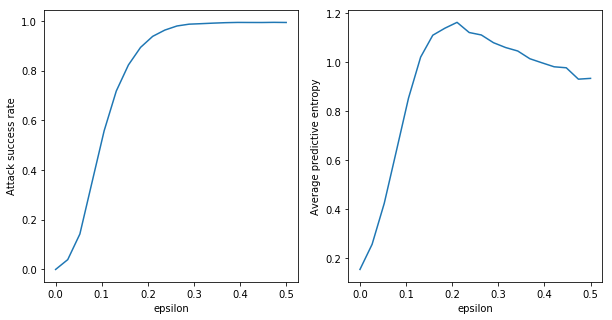

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epsilons,success_rates)
plt.xlabel('epsilon')
plt.ylabel('Attack success rate')
plt.subplot(1,2,2)
plt.plot(epsilons,entropies)
plt.xlabel('epsilon')
plt.ylabel('Average predictive entropy')

In [9]:
epsilons

array([0.        , 0.02631579, 0.05263158, 0.07894737, 0.10526316,
       0.13157895, 0.15789474, 0.18421053, 0.21052632, 0.23684211,
       0.26315789, 0.28947368, 0.31578947, 0.34210526, 0.36842105,
       0.39473684, 0.42105263, 0.44736842, 0.47368421, 0.5       ])